# Data Exploration

## Setup

In [82]:
# Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress, pearsonr
import requests

# Import API keys
from alyssa_config import spoonacular_key, rapidapi_key
# from lakna_config import spoonacular_key

In [275]:
# Check number of items in the Resources subdirectories, to automate file naming.
def recipe_folder():
    count = len(os.listdir('Resources/01_recipe_IDs'))-1
    return(count)

def raw_folder():
    count = len(os.listdir('Resources/02_raw_data'))-1
    return(count)

def simple_folder():
    count = len(os.listdir('Resources/03_simplified_data'))-1
    return(count)

def complex_folder():
    count = len(os.listdir('Resources/04_complex_test'))-1
    return(count)

In [276]:
# Request user input for 'initial_recipes' index of interest.
def check_index():
    try:
        select_folder = input(f"Select file type (recipe, raw, simple, complex): ")
        if (select_folder == "recipe"):
            get_count = recipe_folder()
        elif (select_folder == "raw"):
            get_count = raw_folder()
        elif (select_folder == "simple"):
            get_count = simple_folder()
        elif (select_folder == "complex"):
            get_count = complex_folder()
    except ValueError as e:
        print(f"{e}: Selected file type unknown.")

    try:
        # index = int(input(f"Select file number (0-{recipe_folder()-1}): "))
        index = int(input(f"Select file number (0-{get_count-1}): "))
        return index
    except ValueError as e:
        print(f"{e}: Integer required.")

## Initial Data Exploration - FOOD.COM Dataset
__Goal:__ Understand dataset format and identify attributes.

__PROCESS__
1. Extract the ratings from `RAW_interactions.csv` first.
2. Merge with the `RAW_recipes.csv` then investigate the dataset.

__OBSERVATIONS__
- Nutrition headings: calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV), carbohydrates (PDV)
- Will need to convert the nutrition PDV to actual values later by defining a caloric diet level.

In [9]:
# Import the FOOD.COM datasets as DataFrames.
food_df = pd.read_csv('Resources/RAW_recipes.csv')
interactions_df = pd.read_csv('Resources/RAW_interactions.csv')

In [10]:
# Get the DataFrame dimensions
interactions_shape = interactions_df.shape
print(f"interactions_df: {interactions_shape}")

# Display the DataFrame
interactions_df.head()

interactions_df: (1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [11]:
# Get the DataFrame dimensions and columns
food_shape = food_df.shape
print(f"food_df: {food_shape}")
print(food_df.columns)

# Display the DataFrame
food_df.head()

food_df: (231637, 12)
Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


### Calculate the Average Recipe Rating

In [53]:
# Check how many recipes have ratings
unique_ratings = len(interactions_df['recipe_id'].unique())
print(f"{unique_ratings} out of {food_shape[0]} have ratings.")

# Check how many recipes have a '0' rating
zero_rating = interactions_df.loc[interactions_df['rating'] == 0]['recipe_id'].unique()
print(f"There are {len(zero_rating)} recipes with a '0' rating.")

# Drop the rows with a '0' rating
nonzero_df = interactions_df.loc[interactions_df['rating'] != 0]
print(f"nonzero_df: {nonzero_df.shape}")

231637 out of 231637 have ratings.
There are 35114 recipes with a '0' rating.
nonzero_df: (1071520, 5)


In [13]:
# Create a DataFrame with the average ratings per recipe ID
food_ratings = nonzero_df.groupby('recipe_id')['rating'].mean().reset_index()

# Display the DataFrame
food_ratings.head()

,recipe_id,rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000


In [14]:
# Rename the recipe ID column for merging with food_df
food_ratings = food_ratings.rename(columns={'recipe_id': 'id'})

# Merge the datasets and display updated DataFrame
merged_food = pd.merge(food_df, food_ratings, on='id')

# Display the DataFrame
merged_shape = merged_food.shape
print(f"merged_food: {merged_shape}")
merged_food.head()

merged_food: (226590, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


### Parse the Nutrition Values

In [15]:
# Identify how to split the nutrition string and convert to float
test_string = merged_food['nutrition']

# Remove the square brackets
test_string = test_string[0].strip("[]")

# Split the string to a list
test_string = test_string.split(", ")

# Cast values to float
test_string = [float(value) for value in test_string]
test_string

[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]

In [16]:
# Parse each value in the `nutrition` column
# NOTE: calories (#), total fat (PDV), sugar (PDV), sodium (PDV) , protein (PDV), saturated fat, carbohydrates (PDV)
for df_idx, row in merged_food.iterrows():
    # Strip and split the string to a list
    values_list = row['nutrition'].strip("[]").split(", ")

    # Allocate each nutritional value to the correct column
    for idx, value in enumerate(values_list):
        if (idx == 0):
            merged_food.loc[df_idx, 'Calories'] = float(value)
        elif (idx == 1):
            merged_food.loc[df_idx, 'Total Fat (PDV)'] = float(value)
        elif (idx == 2):
            merged_food.loc[df_idx, 'Sugar (PDV)'] = float(value)
        elif (idx == 3):
            merged_food.loc[df_idx, 'Sodium (PDV)'] = float(value)
        elif (idx == 4):
            merged_food.loc[df_idx, 'Protein (PDV)'] = float(value)
        elif (idx == 5):
            merged_food.loc[df_idx, 'Saturated Fat (PDV)'] = float(value)
        elif (idx == 6):
            merged_food.loc[df_idx, 'Carbohydrates (PDV)'] = float(value)

# Display the DataFrame
merged_food.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [175]:
merged_food.shape

(226590, 20)

### Identify Duplicate Recipes

In [140]:
# Determine whether there are duplicate recipes by ID
dup_id = len(merged_food['id'].unique())
print(f"Unique recipe IDs: {dup_id}, max number of recipes? {merged_shape[0] == dup_id}")

# Determine whether there are duplicate recipes by name
dup_name = len(merged_food['name'].unique())
print(f"Unique recipe names: {dup_name}, max number of recipes? {merged_shape[0] == dup_name}")

# Get the duplicate names - these should be okay
duplicate_names = merged_food.loc[merged_food.duplicated(['name'])]
duplicate_names.head()

Unique recipe IDs: 226590, max number of recipes? True
Unique recipe names: 225190, max number of recipes? False


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
579,cream of mushroom soup,51922,10,59064,2003-01-21,"['15-minutes-or-less', 'time-to-make', 'course...","[472.9, 64.0, 9.0, 38.0, 28.0, 19.0, 5.0]",3,"['place walnuts , garlic water , nama shoyu , ...",if you are not a raw food vegan then try this ...,"['walnuts', 'garlic', 'water', 'shoyu', 'rosem...",8,4.000000,472.9,64.0,9.0,38.0,28.0,19.0,5.0
819,10 bean soup,470575,180,1020526,2011-12-26,"['time-to-make', 'course', 'main-ingredient', ...","[228.0, 10.0, 38.0, 47.0, 42.0, 8.0, 6.0]",9,"['finely chop onion , red and green bell peppe...",we made this without the smoked turkey and ham...,"['beans', 'onion', 'red bell pepper', 'green b...",13,5.000000,228.0,10.0,38.0,47.0,42.0,8.0,6.0
1275,3 bean baked beans,313237,40,407338,2008-07-11,"['60-minutes-or-less', 'time-to-make', 'course...","[329.9, 26.0, 48.0, 39.0, 33.0, 31.0, 9.0]",10,"['fry bacon until crisp , reserving 2 teaspoon...","great for cookouts, family gatherings, potluck...","['bacon', 'ground beef', 'onion', 'tomato sauc...",12,4.000000,329.9,26.0,48.0,39.0,33.0,31.0,9.0
1276,3 bean salad,258846,15,607801,2007-10-13,"['15-minutes-or-less', 'time-to-make', 'course...","[502.3, 44.0, 37.0, 41.0, 24.0, 19.0, 16.0]",6,"['in medium bowl combine mustard , vinegar and...",i got this recipe from one of rachel ray's coo...,"['cut green beans', 'dijon mustard', 'sugar', ...",9,4.000000,502.3,44.0,37.0,41.0,24.0,19.0,16.0
1294,3 ingredient peanut butter cookies,323810,13,138435,2008-09-07,"['15-minutes-or-less', 'time-to-make', 'course...","[197.1, 17.0, 74.0, 4.0, 11.0, 11.0, 6.0]",10,"['preheat oven to 350', 'combine the three ing...",this recipe is so simple. sometimes i put cho...,"['peanut butter', 'sugar', 'egg', 'chocolate c...",4,4.857143,197.1,17.0,74.0,4.0,11.0,11.0,6.0


### Parse the Tags

In [60]:
# Identify how to isolate each tag
tag_string = merged_food['tags'][0].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_tags = []
for string in merged_food['tags']:
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_tags:
            unique_tags.append(tag)

# Display the tags alphabetically
print(f"Number of unique tags: {len(unique_tags)}")
sorted(unique_tags)

Number of unique tags: 547


['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 'breakfast-casserole

#### Extract `Meal Types` from the Tags

In [19]:
# Check the tags for meal types
meal_types = ["breakfast", "lunch", "dinner"]
for meal in meal_types:
    if meal in unique_tags:
        print(f"{meal} is a tag.")
    else:
        print(f"{meal} is not a tag.")

# Look for a similar tag to "dinner"
found = False
for tag in unique_tags:
    if (tag[:6] == "dinner"):
        print(f"{tag} is a match.")
        found = True
if (found is False):
    print("No matches found.")

breakfast is a tag.
lunch is a tag.
dinner is not a tag.
dinner-party is a match.


In [167]:
# Count how many rows contain each meal type
updated_meals = ["breakfast", "lunch", "dinner-party"]

break_count = 0
lunch_count = 0
dinner_count = 0
multiple = 0
total = 0

break_list = []
lunch_list = []
dinner_list = []
multiple_list = []

for idx, string in merged_food.iterrows():
    # Strip and split the string to a list
    tag_list = string['tags'].strip("[]").split(', ')

    # Score tracks mutual exclusivity of the meal types
    score = 0
    # Get each tag from the list and categorise
    for word_idx in range(len(tag_list)):


        # Check the tag
        tag = tag_list[word_idx].strip("'")
        if (tag in updated_meals):
            total += 1
            if (tag == "breakfast"):
                break_list.append(idx)
                break_count += 1
                score += 1
            if (tag == "lunch"):
                lunch_list.append(idx)
                lunch_count += 1
                score += 1
            if (tag == "dinner-party"):
                dinner_list.append(idx)
                dinner_count += 1
                score += 1
            if (score > 1):
                multiple += 1
                multiple_list.append(idx)
                continue

combined_count = break_count + lunch_count + dinner_count
combined_list = break_list + lunch_list + dinner_list
overlap = (total == combined_count)
if (overlap is True):
    conclusion = "Recipes exist in more than one meal type."
elif (overlap is False):
    conclusion = "Recipes belong to only one meal type."

# Print findings
print(f"Total recipes with at least one tag: {total}")
print(32*'*')
print(f"Breakfast: {break_count}")
print(f"Lunch: {lunch_count}")
print(f"Dinner: {dinner_count}")
print(32*'*')
print(f"Multiple: {multiple}")
print(f"Checksum: {combined_count}")
print(f"Overlap? {overlap}. {conclusion}")

Total recipes with at least one tag: 73641
********************************
Breakfast: 13375
Lunch: 23392
Dinner: 36874
********************************
Multiple: 6879
Checksum: 73641
Overlap? True. Recipes exist in more than one meal type.


In [248]:
multiples_df = merged_food.iloc[multiple_list]
multiples_df['tags'][105]

"['time-to-make', 'course', 'preparation', 'occasion', 'appetizers', 'lunch', 'dinner-party', 'holiday-event', 'dietary', 'sandwiches', 'brunch']"

In [180]:
updated_merged = merged_food.iloc[combined_list]
# updated_merged.shape # only recipes with breakfast, lunch, or dinner
updated_merged.shape # (73641, 20)

# delete recipes with multiples
updated_merged = updated_merged.drop(multiple_list)
updated_merged.shape

(60009, 20)

<Axes: xlabel='rating', ylabel='n_ingredients'>

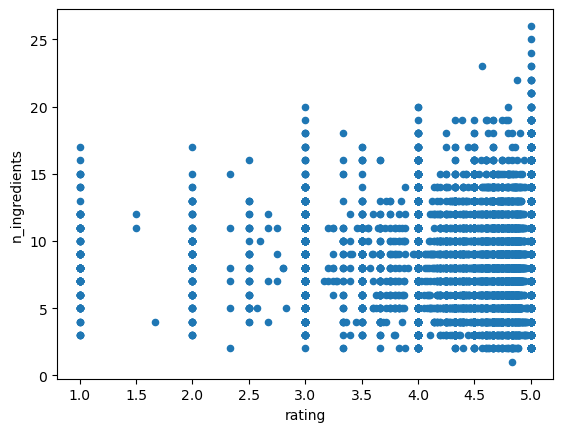

In [80]:
test_df = merged_food.iloc[break_list]
subset = test_df[['rating', 'n_ingredients']]
subset.plot(kind="scatter", x='rating', y='n_ingredients')
# Higher ratings, less ingredients for breakfast.

<Axes: xlabel='n_steps', ylabel='Calories'>

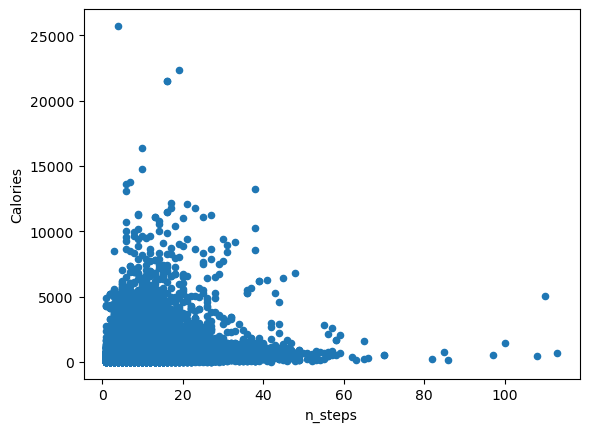

In [81]:
test2_df = merged_food.iloc[combined_list]
# subset2 = test2_df[['n_steps', 'Calories']]
# subset2
# subset2.plot(kind="scatter", x="n_steps", y="Calories")
# print(test2_df.shape)
test2_df.plot(kind="scatter", x="n_steps", y="Calories")

In [78]:
combined_list

73641

#### Extract `Cuisines` from the Tags

In [33]:
input_string = input("List to pass: ")


spoonacular_cuisines = input_string.split(' ')
spoonacular_cuisines = [word.lower() for word in spoonacular_cuisines]
spoonacular_cuisines # DOES NOT ACCOUNT FOR DOUBLE WORD.

# List comprehension to remove double words
double_words = ['eastern', 'european', 'latin', 'american', 'middle']
[spoonacular_cuisines.remove(word) for word in double_words]

# Return the two-word cuisines
spoonacular_cuisines += ['eastern european', 'latin american', 'middle eastern']
spoonacular_cuisines = sorted(spoonacular_cuisines)

List to pass:  African Asian American British Cajun Caribbean Chinese Eastern European European French German Greek Indian Irish Italian Japanese Jewish Korean Latin American Mediterranean Mexican Middle Eastern Nordic Southern Spanish Thai Vietnamese


In [34]:
# Search for matches with FOOD.COM tags
cuisine_match = []
cuisine_mismatch = []
for cuisine in spoonacular_cuisines:
    if cuisine in unique_tags:
        cuisine_match.append(cuisine)
    else:
        cuisine_mismatch.append(cuisine)
print(f"Cuisine match: ({len(cuisine_match)}), {cuisine_match}")
print(f"Cuisine mismatch: ({len(cuisine_mismatch)}), {cuisine_mismatch}")

Cuisine match: (19), ['african', 'american', 'asian', 'cajun', 'caribbean', 'chinese', 'european', 'french', 'german', 'greek', 'indian', 'irish', 'italian', 'japanese', 'korean', 'mexican', 'spanish', 'thai', 'vietnamese']
Cuisine mismatch: (9), ['british', 'eastern', 'eastern european', 'jewish', 'latin american', 'mediterranean', 'middle eastern', 'nordic', 'southern']


In [217]:
updated_merged.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,4.400000,2669.3,160.0,976.0,107.0,62.0,310.0,138.0
52,kitchen sink egg bake,59632,70,79219,2003-04-14,"['weeknight', 'time-to-make', 'course', 'main-...","[794.2, 109.0, 9.0, 30.0, 59.0, 153.0, 3.0]",14,"['preheat oven to 325', 'thaw spinach , and sq...",i call this,"['eggs', 'cottage cheese', 'cheese', 'frozen c...",11,4.000000,794.2,109.0,9.0,30.0,59.0,153.0,3.0
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,4.734694,575.3,18.0,116.0,34.0,28.0,22.0,34.0
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p...",8,5.000000,253.0,13.0,64.0,10.0,11.0,16.0,13.0


In [236]:
total_cuisine = 0
multiple_cuisines = []
has_cuisine = []
for idx, string in updated_merged.iterrows():
    cuisines_list = string['tags'].strip("[]").split(', ')
    score = 0

    # checks every tag in the recipe
    for word_idx in range(len(cuisines_list)):
        cuisine = cuisines_list[word_idx].strip("'")
        if (cuisine in cuisine_match):
            # if (idx not in has_cuisine):
            #     has_cuisine.append(idx)
            total_cuisine += 1
            has_cuisine.append(string['id'])
            score += 1
    if (score > 1):
        multiple_cuisines.append(string['id'])

# Print findings
print(f"Total count of cuisines in the tags: {total_cuisine}")
print(f"Total cuisines with more than one: {len(multiple_cuisines)}")

# unique_cuisines = set(has_cuisine)
# Filter the DataFrame for cuisines with at least one
print(updated_merged.shape)

# Get recipes with at least one cuisine
cuisine_merged = updated_merged.loc[updated_merged['id'].isin(has_cuisine)]
cuisine_merged.shape

# Get recipes with only one cuisine
cuisine_merged = cuisine_merged.loc[~updated_merged['id'].isin(multiple_cuisines)]
cuisine_merged.shape
# print(len(unique_cuisines))
# cuisine_merged = updated_merged.iloc[has_cuisine]
# cuisine_merged
# max(updated_merged.index)

Total count of cuisines in the tags: 32927
Total cuisines with more than one: 8327
(60009, 20)


(15260, 20)

<Axes: xlabel='n_steps', ylabel='minutes'>

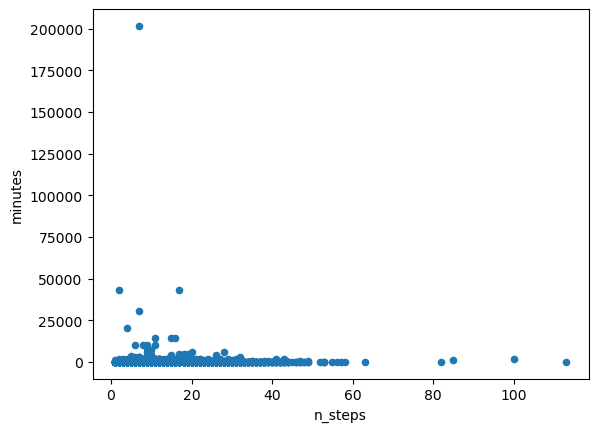

In [241]:
cuisine_merged.plot(kind="scatter", x='n_steps', y='minutes')

In [261]:
minutes_outlier = cuisine_merged['minutes'].max()
minutes_mean = cuisine_merged['minutes'].mean()
minutes_median = cuisine_merged['minutes'].median()


print(f'Minutes mean: {minutes_mean}')
print(f'Minutes median: {minutes_median}')

minutes_agg

Minutes mean: 104.41140235910878
Minutes median: 35.0


In [246]:
check = cuisine_merged.loc[cuisine_merged['minutes'] == minutes_outlier]
check

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
5356,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,"['fennel seed', 'anise seed', 'coriander seeds...",7,4.0,891.8,0.0,906.0,0.0,1.0,0.0,76.0


In [258]:
cuisine_merged

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0
80,rise and shine german fruit pancake,71457,45,93698,2003-09-15,"['60-minutes-or-less', 'time-to-make', 'course...","[253.0, 13.0, 64.0, 10.0, 11.0, 16.0, 13.0]",11,"['preheat oven to 450 degrees', 'with an elect...",source: kbyu's culinary creations with mary cr...,"['eggs', 'flour', 'milk', 'salt', 'butter', 'p...",8,5.000000,253.0,13.0,64.0,10.0,11.0,16.0,13.0
131,blepandekager danish apple pancakes,503475,50,128473,2013-07-08,"['danish', '60-minutes-or-less', 'time-to-make...","[358.2, 30.0, 62.0, 14.0, 19.0, 54.0, 12.0]",10,"['beat the eggs lightly and add the milk', 'co...",this recipe has been posted here for play in z...,"['eggs', 'milk', 'flour', 'sugar', 'salt', 'cr...",10,5.000000,358.2,30.0,62.0,14.0,19.0,54.0,12.0
144,bake in oozy bread,209203,35,86764,2007-02-04,"['bacon', '60-minutes-or-less', 'time-to-make'...","[1063.2, 126.0, 155.0, 74.0, 34.0, 168.0, 21.0]",14,"['preheat oven to 375f', 'place a medium skill...",saw this on the rachael ray show while resting...,"['bacon', 'butter', 'real maple syrup', 'refri...",4,1.666667,1063.2,126.0,155.0,74.0,34.0,168.0,21.0
360,elephant ear dutch baby,368320,25,1232400,2009-04-28,"['30-minutes-or-less', 'time-to-make', 'course...","[552.2, 54.0, 53.0, 13.0, 36.0, 95.0, 13.0]",9,"['preheat oven to 425', 'mix the eggs , flour ...",this recipe is so named because the cinnamon s...,"['butter', 'eggs', 'all-purpose flour', 'milk'...",5,4.333333,552.2,54.0,53.0,13.0,36.0,95.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226255,zucchini parmigiana,180779,25,232669,2006-08-07,"['30-minutes-or-less', 'time-to-make', 'course...","[182.0, 7.0, 31.0, 20.0, 44.0, 5.0, 4.0]",12,"['preheat oven to 400f', 'heat oil in a heavy ...",just a bit different but very good and tasty. ...,"['olive oil', 'garlic cloves', 'italian herb s...",7,4.000000,182.0,7.0,31.0,20.0,44.0,5.0,4.0
226359,zucchini stuffed with tomato white beans and...,493719,24,266635,2013-01-16,"['weeknight', '30-minutes-or-less', 'time-to-m...","[305.7, 23.0, 23.0, 0.0, 24.0, 8.0, 11.0]",9,"['scoop out the zucchini flesh , keeping about...",this recipe will require a large cooker (prefe...,"['zucchini', 'olive oil', 'shallots', 'garlic ...",10,5.000000,305.7,23.0,23.0,0.0,24.0,8.0,11.0
226377,zucchini tomato salsa,321224,20,464080,2008-08-25,"['30-minutes-or-less', 'time-to-make', 'course...","[39.2, 0.0, 25.0, 3.0, 2.0, 0.0, 3.0]",4,"['in a small bowl , combine the first 12 ingre...",a contest winner from taste of home. it state...,"['chopped tomato', 'zucchini', 'red bell peppe...",13,5.000000,39.2,0.0,25.0,3.0,2.0,0.0,3.0
226516,zucchini courgettes sauteed with sun dried to...,413205,40,485109,2010-02-16,"['weeknight', '60-minutes-or-less', 'time-to-m...","[115.4, 7.0, 33.0, 6.0, 8.0, 3.0, 5.0]",12,['place the sundried tomatoes in the 3 / 4 cup...,"this is a lovely mediterranean side dish, and ...","['sun-dried tomatoes', 'warm water', 'olive oi...",8,5.000000,115.4,7.0,33.0,6.0,8.0,3.0,5.0


## Initial Data Exploration - SPOONACULAR API
__Goal:__ Test the API, check returned format and attributes.

__Process__
1. Get recipe IDs, these are needed to pass to other methods (i.e. `Recipe Information`).
2. Get recipe metadata using `Recipe Information`.
3. Save raw response to a CSV to minimise API request repetition.

#### Parse API Response

### Complex Search and Recipe Information
- Complex Search: [https://spoonacular.com/food-api/docs#Search-Recipes-Complex](https://spoonacular.com/food-api/docs#Search-Recipes-Complex)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- `Complex Search` returns the same result every time, need to try `Random Recipes`.

In [ ]:
# API REQUEST - Complex Search.
recipe_url = "https://api.spoonacular.com/recipes/complexSearch"

# Set request parameters
recipe_params = {
    'apiKey': spoonacular_key,
    'number': 100}

# Request a list of recipes.
recipe_response = requests.get(recipe_url, recipe_params).json()

# Output response to a csv
recipes_df = pd.DataFrame(recipe_response['results'])
recipes_df.to_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv', index=False)

In [ ]:
# Import and display complex search results
recipes_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv')
recipes_df.head()

In [ ]:
# Check the number of returned recipes
print(f'Number of recipes returned: {len(recipes_df)}')

In [ ]:
# API REQUEST - Recipe Information
recipe_info = []
for id in recipes_df['id']:
    info_url = f"https://api.spoonacular.com/recipes/{id}/information?"
    info_params = {
        'apiKey': spoonacular_key,
        'includeNutrition': "true"}

    info_response = requests.get(info_url, info_params).json()
    recipe_info.append(info_response)

info_df = pd.DataFrame(recipe_info)
info_df.to_csv(f'Resources/02_raw_data/info_master_0.csv')

In [ ]:
# While the API response is accessible, identify attributes of interest
recipe_info[0].keys()

# Generic metadata
recipe_info[0]['id']
recipe_info[0]['title']
recipe_info[0]['aggregateLikes'] # will need to convert this to a 5-point scale
recipe_info[0]['extendedIngredients'] # can use len() to get the number of ingredients
recipe_info[0]['weightWatcherSmartPoints'] # research the equation for this
recipe_info[0]['cuisines'] # identify recipes with non-empty results
recipe_info[0]['dishTypes'] # will need to select a simpler subset

# Nutritional values - amount, unit, percent of daily needs
recipe_info[0]['nutrition']['nutrients'][0] # Calories
recipe_info[0]['nutrition']['nutrients'][2] # Saturated Fat
recipe_info[0]['nutrition']['nutrients'][5] # Sugar
recipe_info[0]['nutrition']['nutrients'][7] # Sodium
recipe_info[0]['nutrition']['nutrients'][8] # Protein

In [ ]:
# Import and display recipe information results
info_df = pd.read_csv(f'Resources/02_raw_data/info_master_0.csv')

# Get the list of column names
info_df.columns

# Display the dataframe
info_df.head()

### Random Recipes and Recipe Information
- Random Recipes: [https://spoonacular.com/food-api/docs#Get-Random-Recipes](https://spoonacular.com/food-api/docs#Get-Random-Recipes)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- Once converted to a dataframe, the data is not as accessible as navigating the API response, will need to create a simplified dataframe while the API response is available.
- Although this has metadata, it still does not have `Nutrition` information, will still need to run the `Recipe Information` request. Need to identify a cost-effective API request methodology.

In [ ]:
# API REQUEST - Random Recipe
random_url = "https://api.spoonacular.com/recipes/random?"

# Set request parameters
random_params = {
    'apiKey': spoonacular_key,
    'number': 100}

# Request a list of random recipe IDs.
random_response = requests.get(random_url, random_params).json()

# Output response to a csv
random_df = pd.DataFrame(random_response['recipes'])
random_df.to_csv(f'Resources/01_recipe_IDs/initial_recipes_4.csv', index=False)

In [ ]:
# Import and display random recipes results
random_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_4.csv')
random_df.head()

In [ ]:
# Get the list of column name
random_df.columns

In [ ]:
# API REQUEST - Recipe Information
recipe_info = []
for id in random_df['id']:
    info_url = f"https://api.spoonacular.com/recipes/{id}/information?"
    info_params = {
        'apiKey': spoonacular_key,
        'includeNutrition': "true"}

    info_response = requests.get(info_url, info_params).json()
    recipe_info.append(info_response)

info_df = pd.DataFrame(recipe_info)
info_df.to_csv(f'Resources/02_raw_data/info_master_4.csv')

In [ ]:
# Display the dataframe
info_df.head()

### Parse API Response

__OBSERVATIONS__
- Ensure all relevant columns are accounted for before bulk requesting.
- Will need to account for different units.

In [ ]:
# Metadata
recipe_id = []
recipe_name = []
recipe_likes = []
meal_type = []
cuisines = []
num_ingredients = []
ww_points = []

# Calories
calories_amt = []
calories_unit = []
calories_pct = []

# Saturated Fat
satfat_amt = []
satfat_unit = []
satfat_pct = []

# Sugar
sugar_amt = []
sugar_unit = []
sugar_pct = []

# Sodium
sodium_amt = []
sodium_unit = []
sodium_pct = []

# Protein
protein_amt = []
protein_unit = []
protein_pct = []

for idx, row in enumerate(recipe_info):
    try:
        recipe_id.append(recipe_info[idx]['id'])
        recipe_name.append(recipe_info[idx]['title'])
        recipe_likes.append(recipe_info[idx]['aggregateLikes'])
        meal_type.append(recipe_info[idx]['dishTypes'])
        cuisines.append(recipe_info[idx]['cuisines'])
        num_ingredients.append(len(recipe_info[idx]['extendedIngredients']))
        ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])
        
        calories_amt.append(recipe_info[idx]['nutrition']['nutrients'][0]['amount'])
        calories_unit.append(recipe_info[idx]['nutrition']['nutrients'][0]['unit'])
        calories_pct.append(recipe_info[idx]['nutrition']['nutrients'][0]['percentOfDailyNeeds'])
        
        satfat_amt.append(recipe_info[idx]['nutrition']['nutrients'][2]['amount'])
        satfat_unit.append(recipe_info[idx]['nutrition']['nutrients'][2]['unit'])
        satfat_pct.append(recipe_info[idx]['nutrition']['nutrients'][2]['percentOfDailyNeeds'])
        
        sugar_amt.append(recipe_info[idx]['nutrition']['nutrients'][5]['amount'])
        sugar_unit.append(recipe_info[idx]['nutrition']['nutrients'][5]['unit'])
        sugar_pct.append(recipe_info[idx]['nutrition']['nutrients'][5]['percentOfDailyNeeds'])
        
        sodium_amt.append(recipe_info[idx]['nutrition']['nutrients'][7]['amount'])
        sodium_unit.append(recipe_info[idx]['nutrition']['nutrients'][7]['unit'])
        sodium_pct.append(recipe_info[idx]['nutrition']['nutrients'][7]['percentOfDailyNeeds'])
        
        protein_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
        protein_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
        protein_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])
    
    except:
        print(idx)

spoonacular_df = pd.DataFrame({
    'ID': recipe_id,
    'Name': recipe_name,
    'Likes': recipe_likes,
    'Meal Type': meal_type,
    'Cuisines': cuisines,
    'N_ingredients': num_ingredients,
    'WW Smart Points': ww_points,
    'Calories (Amount)': calories_amt,
    'Calories (Unit)': calories_unit,
    'Calories (% of Daily Needs)': calories_pct,
    'Saturated Fat (Amount)': satfat_amt,
    'Saturated Fat (Unit)': satfat_unit,
    'Saturated Fat (% of Daily Needs)': satfat_pct,
    'Sugar (Amount)': sugar_amt,
    'Sugar (Unit)': sugar_unit,
    'Sugar (% of Daily Needs)': sugar_pct,
    'Sodium (Amount)': sodium_amt,
    'Sodium (Unit)': sodium_unit,
    'Sodium (% of Daily Needs)': sodium_pct,
    'Protein (Amount)': protein_amt,
    'Protein (Unit)': protein_unit,
    'Protein (% of Daily Needs)': protein_pct})

spoonacular_df.to_csv(f"Resources/03_simplified_data/initial_nutrition_4.csv", index=False)

In [ ]:
# Check the units columns
units_columns = ['Calories (Unit)', 'Saturated Fat (Unit)', 'Sugar (Unit)', 'Sodium (Unit)', 'Protein (Unit)']
for col in units_columns:
    check = spoonacular_df['Protein (Unit)'].unique()
    print(f"Unit check: {col} {check}")

### Random Recipes and Nutrition by ID

In [ ]:
# API REQUEST - Random Recipe
random_url = "https://api.spoonacular.com/recipes/random?"

# Set request parameters
random_params = {
    'apiKey': spoonacular_key,
    'number': 100}

# Request a list of random recipe IDs.
random_response = requests.get(random_url, random_params).json()

# Output response to a csv
random_df = pd.DataFrame(random_response['recipes'])
random_df.to_csv('Resources/01_recipe_IDs/initial_recipes_5.csv', index=False)

In [ ]:
# API REQUEST - Nutrition by ID
nutrition_info = []
for id in random_df['id']:
    nutrition_url = f"https://api.spoonacular.com/recipes/{id}/nutritionWidget.json"
    nutrition_params = {'apiKey': spoonacular_key}

    nutrition_response = requests.get(nutrition_url, nutrition_params).json()
    nutrition_info.append(nutrition_response)

nutrition_df = pd.DataFrame(nutrition_info)
nutrition_df.to_csv('Resources/02_raw_data/info_master_5.csv')

In [ ]:
metadata.columns

In [ ]:
nutrition_info[0]['carbs']

In [ ]:
# Parse results
metadata = pd.read_csv('Resources/01_recipe_IDs/initial_recipes_5.csv')
metadata

# Metadata
num_ingredients = []
carbs = []
# for row in metadata['extendedIngredients']:
#     print(row)

# Calories
calories_amt = []
calories_unit = []
calories_pct = []

# Saturated Fat
satfat_amt = []
satfat_unit = []
satfat_pct = []

# Sugar
sugar_amt = []
sugar_unit = []
sugar_pct = []

# Sodium
sodium_amt = []
sodium_unit = []
sodium_pct = []

# Protein
protein_amt = []
protein_unit = []
protein_pct = []

for idx, row in enumerate(nutrition_info):
    try:
        # recipe_id.append(nutrition_info[idx]['id'])
        # recipe_name.append(nutrition_info[idx]['title'])
        # recipe_likes.append(nutrition_info[idx]['aggregateLikes'])
        # meal_type.append(nutrition_info[idx]['dishTypes'])
        # cuisines.append(nutrition_info[idx]['cuisines'])
        # num_ingredients.append(len(recipe_info[idx]['extendedIngredients']))
        # ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])

        num_ingredients.append(len(nutrition_info[idx]['ingredients']))
        carbs.append(nutrition_info[idx]['carbs'])
        calories_amt.append(nutrition_info[idx]['nutrients'][0]['amount'])
        calories_unit.append(nutrition_info[idx]['nutrients'][0]['unit'])
        calories_pct.append(nutrition_info[idx]['nutrients'][0]['percentOfDailyNeeds'])
        
        satfat_amt.append(nutrition_info[idx]['nutrients'][2]['amount'])
        satfat_unit.append(nutrition_info[idx]['nutrients'][2]['unit'])
        satfat_pct.append(nutrition_info[idx]['nutrients'][2]['percentOfDailyNeeds'])
        
        sugar_amt.append(nutrition_info[idx]['nutrients'][5]['amount'])
        sugar_unit.append(nutrition_info[idx]['nutrients'][5]['unit'])
        sugar_pct.append(nutrition_info[idx]['nutrients'][5]['percentOfDailyNeeds'])
        
        sodium_amt.append(nutrition_info[idx]['nutrients'][7]['amount'])
        sodium_unit.append(nutrition_info[idx]['nutrients'][7]['unit'])
        sodium_pct.append(nutrition_info[idx]['nutrients'][7]['percentOfDailyNeeds'])
        
        protein_amt.append(nutrition_info[idx]['nutrients'][8]['amount'])
        protein_unit.append(nutrition_info[idx]['nutrients'][8]['unit'])
        protein_pct.append(nutrition_info[idx]['nutrients'][8]['percentOfDailyNeeds'])
    
    except:
        print(idx)

spoonacular_df = pd.DataFrame({
    'ID': metadata['id'],
    'Name': metadata['title'],
    'Likes': metadata['aggregateLikes'],
    'Meal Type': metadata['dishTypes'],
    'Cuisines': metadata['cuisines'],
    'N_ingredients': num_ingredients,
    'WW Smart Points': metadata['weightWatcherSmartPoints'],
    'Calories (Amount)': calories_amt,
    'Calories (Unit)': calories_unit,
    'Calories (% of Daily Needs)': calories_pct,
    'Saturated Fat (Amount)': satfat_amt,
    'Saturated Fat (Unit)': satfat_unit,
    'Saturated Fat (% of Daily Needs)': satfat_pct,
    'Sugar (Amount)': sugar_amt,
    'Sugar (Unit)': sugar_unit,
    'Sugar (% of Daily Needs)': sugar_pct,
    'Sodium (Amount)': sodium_amt,
    'Sodium (Unit)': sodium_unit,
    'Sodium (% of Daily Needs)': sodium_pct,
    'Protein (Amount)': protein_amt,
    'Protein (Unit)': protein_unit,
    'Protein (% of Daily Needs)': protein_pct,
    'Carbohydrates': carbs})

spoonacular_df.to_csv(f"Resources/03_simplified_data/initial_nutrition_5.csv", index=False)

# Data Collection
- API request cost comparison:
    1. `Random Recipes` + `Recipe Information` = 2.1 points per request
    2. `Random Recipes` + `Nutrition` = 2 points per request

In [85]:
# API REQUEST - Random Recipe
random_url = "https://api.spoonacular.com/recipes/random?"

# Set request parameters
random_params = {
    'apiKey': spoonacular_key,
    'number': 100}

# Request a list of random recipe IDs.
random_response = requests.get(random_url, random_params).json()

# Output response to a csv
random_df = pd.DataFrame(random_response['recipes'])
random_df.to_csv(f'Resources/01_recipe_IDs/initial_recipes_{recipe_folder()}.csv', index=False)

In [86]:
# API REQUEST - Nutrition by ID
nutrition_info = []
for id in random_df['id']:
    nutrition_url = f"https://api.spoonacular.com/recipes/{id}/nutritionWidget.json"
    nutrition_params = {'apiKey': spoonacular_key}

    nutrition_response = requests.get(nutrition_url, nutrition_params).json()
    nutrition_info.append(nutrition_response)

nutrition_df = pd.DataFrame(nutrition_info)
nutrition_df.to_csv(f'Resources/02_raw_data/info_master_{raw_folder()}.csv')

In [87]:
# Parse results
metadata = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_{recipe_folder()-1}.csv')
metadata

# Metadata
num_ingredients = []
carbs = []
# for row in metadata['extendedIngredients']:
#     print(row)

# Calories
calories_amt = []
calories_unit = []
calories_pct = []

# Saturated Fat
satfat_amt = []
satfat_unit = []
satfat_pct = []

# Sugar
sugar_amt = []
sugar_unit = []
sugar_pct = []

# Sodium
sodium_amt = []
sodium_unit = []
sodium_pct = []

# Protein
protein_amt = []
protein_unit = []
protein_pct = []

for idx, row in enumerate(nutrition_info):
    try:
        # recipe_id.append(nutrition_info[idx]['id'])
        # recipe_name.append(nutrition_info[idx]['title'])
        # recipe_likes.append(nutrition_info[idx]['aggregateLikes'])
        # meal_type.append(nutrition_info[idx]['dishTypes'])
        # cuisines.append(nutrition_info[idx]['cuisines'])
        # num_ingredients.append(len(recipe_info[idx]['extendedIngredients']))
        # ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])

        num_ingredients.append(len(nutrition_info[idx]['ingredients']))
        carbs.append(nutrition_info[idx]['carbs'])
        calories_amt.append(nutrition_info[idx]['nutrients'][0]['amount'])
        calories_unit.append(nutrition_info[idx]['nutrients'][0]['unit'])
        calories_pct.append(nutrition_info[idx]['nutrients'][0]['percentOfDailyNeeds'])
        
        satfat_amt.append(nutrition_info[idx]['nutrients'][2]['amount'])
        satfat_unit.append(nutrition_info[idx]['nutrients'][2]['unit'])
        satfat_pct.append(nutrition_info[idx]['nutrients'][2]['percentOfDailyNeeds'])
        
        sugar_amt.append(nutrition_info[idx]['nutrients'][5]['amount'])
        sugar_unit.append(nutrition_info[idx]['nutrients'][5]['unit'])
        sugar_pct.append(nutrition_info[idx]['nutrients'][5]['percentOfDailyNeeds'])
        
        sodium_amt.append(nutrition_info[idx]['nutrients'][7]['amount'])
        sodium_unit.append(nutrition_info[idx]['nutrients'][7]['unit'])
        sodium_pct.append(nutrition_info[idx]['nutrients'][7]['percentOfDailyNeeds'])
        
        protein_amt.append(nutrition_info[idx]['nutrients'][8]['amount'])
        protein_unit.append(nutrition_info[idx]['nutrients'][8]['unit'])
        protein_pct.append(nutrition_info[idx]['nutrients'][8]['percentOfDailyNeeds'])
    
    except:
        print(idx)
        pass

spoonacular_df = pd.DataFrame({
    'ID': metadata['id'],
    'Name': metadata['title'],
    'Likes': metadata['aggregateLikes'],
    'Meal Type': metadata['dishTypes'],
    'Cuisines': metadata['cuisines'],
    'N_ingredients': num_ingredients,
    'WW Smart Points': metadata['weightWatcherSmartPoints'],
    'Calories (Amount)': calories_amt,
    'Calories (Unit)': calories_unit,
    'Calories (% of Daily Needs)': calories_pct,
    'Saturated Fat (Amount)': satfat_amt,
    'Saturated Fat (Unit)': satfat_unit,
    'Saturated Fat (% of Daily Needs)': satfat_pct,
    'Sugar (Amount)': sugar_amt,
    'Sugar (Unit)': sugar_unit,
    'Sugar (% of Daily Needs)': sugar_pct,
    'Sodium (Amount)': sodium_amt,
    'Sodium (Unit)': sodium_unit,
    'Sodium (% of Daily Needs)': sodium_pct,
    'Protein (Amount)': protein_amt,
    'Protein (Unit)': protein_unit,
    'Protein (% of Daily Needs)': protein_pct,
    'Carbohydrates': carbs})

spoonacular_df.to_csv(f"Resources/03_simplified_data/initial_nutrition_{simple_folder()}.csv", index=False)

# Data Cleaning

## Add missing values from the raw data

In [108]:
simplified_data = pd.read_csv(f'Resources/03_simplified_data/initial_nutrition_{check_index()}.csv')
simplified_data.columns
simplified_data.shape

Select file type (recipe, raw, simple):  simple
Select file number (0-11):  3


(33, 21)

In [109]:
simplified_data.head()

,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),Saturated Fat (Amount),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,645384,Greek Yogurt Chicken Salad,4,"['lunch', 'main course', 'main dish', 'dinner']","['Mediterranean', 'European', 'Greek']",7,334.09,kcal,16.70,2.45,...,15.31,9.21,g,10.24,318.44,mg,13.85,41.31,g,82.62
1,636271,Brooklyn Blackout Cake,6,['dessert'],[],14,328.77,kcal,16.44,7.57,...,47.34,8.25,g,9.16,305.10,mg,13.27,29.67,mg,9.89
2,639137,Chocolate Pavlova with Winter Fruit,13,['dessert'],[],12,283.94,kcal,14.20,10.35,...,64.70,29.74,g,33.05,32.36,mg,1.41,5.70,mg,1.90
3,634229,Bananas Foster,4,['dessert'],"['Creole', 'Cajun']",7,507.90,kcal,25.40,7.33,...,45.82,66.50,g,73.89,105.02,mg,4.57,13.06,g,72.57
4,660283,SLOW COOKER CHICKEN GUMBO SOUP,2,"['antipasti', 'soup', 'starter', 'snack', 'app...","['Creole', 'Cajun']",14,351.07,kcal,17.55,1.37,...,8.55,6.26,g,6.96,764.99,mg,33.26,12.98,g,25.96


In [111]:
raw_data = pd.read_csv(f'Resources/02_raw_data/info_master_{check_index()}.csv')
raw_data['weightWatcherSmartPoints']

Select file type (recipe, raw, simple):  raw
Select file number (0-11):  3


0      6.0
1     12.0
2     13.0
3     14.0
4      5.0
      ... 
95     NaN
96     NaN
97     NaN
98     NaN
99     NaN
Name: weightWatcherSmartPoints, Length: 100, dtype: float64

In [112]:
simplified_data.insert(6, column='WW Smart Points', value=raw_data['weightWatcherSmartPoints'])

In [113]:
simplified_data.head()

,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,645384,Greek Yogurt Chicken Salad,4,"['lunch', 'main course', 'main dish', 'dinner']","['Mediterranean', 'European', 'Greek']",7,6.0,334.09,kcal,16.70,...,15.31,9.21,g,10.24,318.44,mg,13.85,41.31,g,82.62
1,636271,Brooklyn Blackout Cake,6,['dessert'],[],14,12.0,328.77,kcal,16.44,...,47.34,8.25,g,9.16,305.10,mg,13.27,29.67,mg,9.89
2,639137,Chocolate Pavlova with Winter Fruit,13,['dessert'],[],12,13.0,283.94,kcal,14.20,...,64.70,29.74,g,33.05,32.36,mg,1.41,5.70,mg,1.90
3,634229,Bananas Foster,4,['dessert'],"['Creole', 'Cajun']",7,14.0,507.90,kcal,25.40,...,45.82,66.50,g,73.89,105.02,mg,4.57,13.06,g,72.57
4,660283,SLOW COOKER CHICKEN GUMBO SOUP,2,"['antipasti', 'soup', 'starter', 'snack', 'app...","['Creole', 'Cajun']",14,5.0,351.07,kcal,17.55,...,8.55,6.26,g,6.96,764.99,mg,33.26,12.98,g,25.96


In [114]:
simplified_data.to_csv('Resources/03_simplified_data/initial_nutrition_3.csv', index=False)

## Test plot on one dataset

R-value: 0.0192


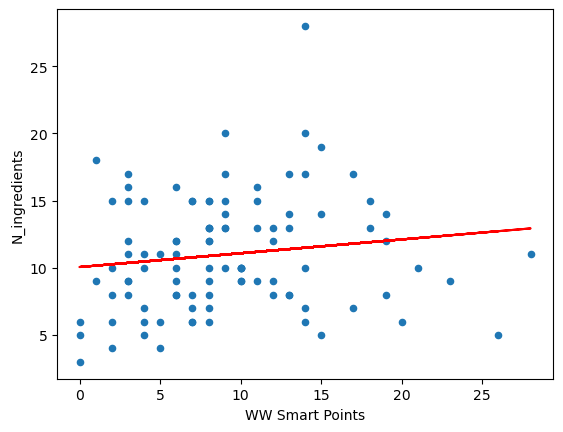

In [52]:
x_values = simplified_data["WW Smart Points"]
y_values = simplified_data["N_ingredients"]
scatter_plot = simplified_data.plot(kind="scatter", x="WW Smart Points", y="N_ingredients")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regression_values = x_values * slope + intercept

r_value = pearsonr(x_values, y_values)
print(f"R-value: {round(r_value[0]**2, 4)}")
plt.plot(x_values, regression_values, color='red')
plt.show()

## Get RECIPE IDs without data

In [314]:
cuisine_match
cuisine_string = str(cuisine_match)
cuisine_string = cuisine_string.strip("[]")
cuisine_string = cuisine_string.replace(" ","")
cuisine_string

"'african','american','asian','cajun','caribbean','chinese','european','french','german','greek','indian','irish','italian','japanese','korean','mexican','spanish','thai','vietnamese'"

In [315]:
# API REQUEST - Complex Search.
recipe_url = "https://api.spoonacular.com/recipes/complexSearch"

# Set request parameters
recipe_params = {
    'apiKey': spoonacular_key,
    'number': 100,
    # 'excludeCuisine': cuisine_mismatch,
    # 'cuisine': "african,american,asian,cajun,caribbean,chinese,european,french,german,greek,indian,,
    'cuisine': cuisine_string,
    'type': "dinner",
    'addRecipeNutrition': True}

# Request a list of recipes.
recipe_response = requests.get(recipe_url, recipe_params).json()
recipe_response

# Output response to a csv
recipes_df = pd.DataFrame(recipe_response['results'])
recipes_df.to_csv(f'Resources/04_complex_test/recipe_data_{complex_folder()}.csv', index=False)

In [297]:
recipe_response['results'][0]['nutrition']['ingredients']

[{'id': 1009040,
  'name': 'banana',
  'amount': 0.25,
  'unit': 'cup',
  'nutrients': [{'name': 'Calories',
    'amount': 50.06,
    'unit': 'kcal',
    'percentOfDailyNeeds': 22.85},
   {'name': 'Copper',
    'amount': 0.04,
    'unit': 'mg',
    'percentOfDailyNeeds': 20.21},
   {'name': 'Zinc',
    'amount': 0.08,
    'unit': 'mg',
    'percentOfDailyNeeds': 20.16},
   {'name': 'Vitamin K',
    'amount': 0.28,
    'unit': 'µg',
    'percentOfDailyNeeds': 1.99},
   {'name': 'Alcohol', 'amount': 0.0, 'unit': 'g', 'percentOfDailyNeeds': 0.0},
   {'name': 'Iron',
    'amount': 0.15,
    'unit': 'mg',
    'percentOfDailyNeeds': 14.35},
   {'name': 'Vitamin B2',
    'amount': 0.04,
    'unit': 'mg',
    'percentOfDailyNeeds': 60.64},
   {'name': 'Sodium',
    'amount': 0.56,
    'unit': 'mg',
    'percentOfDailyNeeds': 17.43},
   {'name': 'Net Carbohydrates',
    'amount': 11.36,
    'unit': 'g',
    'percentOfDailyNeeds': 24.92},
   {'name': 'Carbohydrates',
    'amount': 12.82,
    'un

In [316]:
# Metadata
recipe_id = []
recipe_name = []
recipe_likes = []
meal_type = []
cuisines = []
num_ingredients = []
ww_points = []
mins_cook = []
mins_prep = []

# Calories
calories_amt = []
calories_unit = []
calories_pct = []

# Saturated Fat
satfat_amt = []
satfat_unit = []
satfat_pct = []

# Sugar
sugar_amt = []
sugar_unit = []
sugar_pct = []

# Sodium
sodium_amt = []
sodium_unit = []
sodium_pct = []

# Protein
protein_amt = []
protein_unit = []
protein_pct = []

# Carbohydrates
carbs_amt = []
carbs_unit = []
carbs_pct = []

recipe_info = recipe_response['results']
for idx, row in enumerate(recipe_info):
    recipe_id.append(recipe_info[idx]['id'])
    recipe_name.append(recipe_info[idx]['title'])
    recipe_likes.append(recipe_info[idx]['aggregateLikes'])
    meal_type.append(recipe_info[idx]['dishTypes'])
    cuisines.append(recipe_info[idx]['cuisines'])
    num_ingredients.append(len(recipe_info[idx]['nutrition']['ingredients']))
    ww_points.append(recipe_info[idx]['weightWatcherSmartPoints'])
    mins_cook.append(recipe_info[idx]['cookingMinutes'])
    mins_prep.append(recipe_info[idx]['preparationMinutes'])
    
    calories_amt.append(recipe_info[idx]['nutrition']['nutrients'][0]['amount'])
    calories_unit.append(recipe_info[idx]['nutrition']['nutrients'][0]['unit'])
    calories_pct.append(recipe_info[idx]['nutrition']['nutrients'][0]['percentOfDailyNeeds'])
    
    satfat_amt.append(recipe_info[idx]['nutrition']['nutrients'][2]['amount'])
    satfat_unit.append(recipe_info[idx]['nutrition']['nutrients'][2]['unit'])
    satfat_pct.append(recipe_info[idx]['nutrition']['nutrients'][2]['percentOfDailyNeeds'])
    
    sugar_amt.append(recipe_info[idx]['nutrition']['nutrients'][5]['amount'])
    sugar_unit.append(recipe_info[idx]['nutrition']['nutrients'][5]['unit'])
    sugar_pct.append(recipe_info[idx]['nutrition']['nutrients'][5]['percentOfDailyNeeds'])
    
    sodium_amt.append(recipe_info[idx]['nutrition']['nutrients'][7]['amount'])
    sodium_unit.append(recipe_info[idx]['nutrition']['nutrients'][7]['unit'])
    sodium_pct.append(recipe_info[idx]['nutrition']['nutrients'][7]['percentOfDailyNeeds'])
    
    protein_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
    protein_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
    protein_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])

    carbs_amt.append(recipe_info[idx]['nutrition']['nutrients'][8]['amount'])
    carbs_unit.append(recipe_info[idx]['nutrition']['nutrients'][8]['unit'])
    carbs_pct.append(recipe_info[idx]['nutrition']['nutrients'][8]['percentOfDailyNeeds'])

spoonacular_df = pd.DataFrame({
    'ID': recipe_id,
    'Name': recipe_name,
    'Likes': recipe_likes,
    'Meal Type': meal_type,
    'Cuisines': cuisines,
    'N_ingredients': num_ingredients,
    'WW Smart Points': ww_points,
    'Cooking Minutes': mins_cook,
    'Prep Minutes': mins_prep,
    'Calories (Amount)': calories_amt,
    'Calories (Unit)': calories_unit,
    'Calories (% of Daily Needs)': calories_pct,
    'Saturated Fat (Amount)': satfat_amt,
    'Saturated Fat (Unit)': satfat_unit,
    'Saturated Fat (% of Daily Needs)': satfat_pct,
    'Sugar (Amount)': sugar_amt,
    'Sugar (Unit)': sugar_unit,
    'Sugar (% of Daily Needs)': sugar_pct,
    'Sodium (Amount)': sodium_amt,
    'Sodium (Unit)': sodium_unit,
    'Sodium (% of Daily Needs)': sodium_pct,
    'Protein (Amount)': protein_amt,
    'Protein (Unit)': protein_unit,
    'Protein (% of Daily Needs)': protein_pct,
    'Carbs (Amount)': carbs_amt,
    'Carbs (Unit)': carbs_unit,
    'Carbs (% of Daily Needs)': carbs_pct})

spoonacular_df.to_csv(f"Resources/04_complex_test/simplified_data_{complex_folder()-2}.csv", index=False)

## Combine all the spreadsheets

In [131]:
#identifing the column name of each nutrition csv's
nutrition0_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_0.csv")
nutrition1_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_1.csv")
nutrition2_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_2.csv")
nutrition3_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_3.csv")
nutrition4_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_4.csv")
nutrition5_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_5.csv")
nutrition7_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_7.csv")
nutrition10_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_10.csv")
nutrition11_df = pd.read_csv("Resources/03_simplified_data/initial_nutrition_11.csv")
#nutrition1_df.count()

In [184]:
nutrition_all = pd.concat(
    [nutrition0_df, nutrition1_df, nutrition2_df, nutrition3_df, nutrition4_df, nutrition5_df,
     nutrition7_df, nutrition10_df, nutrition11_df], ignore_index=True)
nutrition_all = nutrition_all.drop(columns='Carbohydrates')
nutrition_all.head()

,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12.0,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",3689,"['side dish', 'antipasti', 'starter', 'snack',...","['Chinese', 'Asian']",15,4.0,220.82,kcal,11.04,...,6.99,5.29,g,5.87,445.90,mg,19.39,9.03,g,18.05
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15.0,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11.0,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
4,716406,Asparagus and Pea Soup: Real Convenience Food,207,"['antipasti', 'soup', 'starter', 'snack', 'app...",[],8,2.0,452.33,kcal,22.62,...,8.34,27.99,g,31.10,25.76,mg,1.12,26.56,g,53.12


In [209]:
# Check for duplicate IDs
nutrition_duplicates = nutrition_all.loc[nutrition_all.duplicated(['ID'])]
duplicates = len(nutrition_duplicates)
duplicates

nutrition_unique = nutrition_all.drop_duplicates(subset=['ID'])
nutrition_unique.head()

,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12.0,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",3689,"['side dish', 'antipasti', 'starter', 'snack',...","['Chinese', 'Asian']",15,4.0,220.82,kcal,11.04,...,6.99,5.29,g,5.87,445.90,mg,19.39,9.03,g,18.05
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15.0,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11.0,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
4,716406,Asparagus and Pea Soup: Real Convenience Food,207,"['antipasti', 'soup', 'starter', 'snack', 'app...",[],8,2.0,452.33,kcal,22.62,...,8.34,27.99,g,31.10,25.76,mg,1.12,26.56,g,53.12


## Get meal types

In [151]:
nutrition_unique['Meal Type'][0]

"['side dish', 'lunch', 'main course', 'salad', 'main dish', 'dinner']"

In [148]:
# Get a list of meal types
unique_meals = []
for string in nutrition_unique['Meal Type']:
    meal_list = string.strip("[]").split(', ')
    for word_idx in range(len(meal_list)):
        meal = meal_list[word_idx].strip("'")
        if meal not in unique_meals:
            unique_meals.append(meal)

# Display the tags alphabetically
print(f"Number of unique meals: {len(unique_meals)}")
sorted(unique_meals)

Number of unique meals: 28


['',
 '"hor d\'oeuvre"',
 'antipasti',
 'antipasto',
 'appetizer',
 'beverage',
 'bread',
 'breakfast',
 'brunch',
 'condiment',
 'dessert',
 'dinner',
 'dip',
 'drink',
 'fingerfood',
 'lunch',
 'main course',
 'main dish',
 'marinade',
 'morning meal',
 'salad',
 'sauce',
 'seasoning',
 'side dish',
 'snack',
 'soup',
 'spread',
 'starter']

In [271]:
# Count how many rows contain each meal type
meal_types = ["breakfast", "lunch", "dinner"]

break_count = 0
lunch_count = 0
dinner_count = 0
multiple = 0
total = 0

break_list = []
lunch_list = []
dinner_list = []
multiple_list = []

for idx, string in nutrition_unique.iterrows():
    # Strip and split the string to a list
    meal_list = string['Meal Type'].strip("[]").split(', ')
    # print(meal_list)
    # Get each tag from the list and categorise

    # Score tracks mutual exclusivity of the meal types
    score = 0
    for word_idx in range(len(meal_list)):
        # Check the tag
        meal = meal_list[word_idx].strip("'")
        # print(meal)     

        if (meal in meal_types):
            total += 1
            if (meal == "breakfast"):
                break_list.append(string['ID'])
                break_count += 1
                score += 1
            if (meal == "lunch"):
                lunch_list.append(string['ID'])
                lunch_count += 1
                score += 1
            if (meal == "dinner"):
                dinner_list.append(string['ID'])
                dinner_count += 1
                score += 1
            if (score > 1):
                multiple_list.append(string['ID'])
                multiple += 1

combined_count = break_count + lunch_count + dinner_count
combined_list = break_list + lunch_list + dinner_list
overlap = not(total == combined_count)
if (overlap is True):
    conclusion = "Recipes exist in more than one meal type."
elif (overlap is False):
    conclusion = "Recipes belong to only one meal type."

# Print findings
print(f"Total recipes with at least one tag: {total}")
print(32*'*')
print(f"Breakfast: {break_count}")
print(f"Lunch: {lunch_count}")
print(f"Dinner: {dinner_count}")
print(32*'*')
print(f"Multiple: {multiple}")
print(f"Checksum: {combined_count}")
print(f"Overlap? {overlap}. {conclusion}")

Total recipes with at least one tag: 529
********************************
Breakfast: 53
Lunch: 238
Dinner: 238
********************************
Multiple: 243
Checksum: 529
Overlap? False. Recipes belong to only one meal type.


In [273]:
# Isolate recipes which have: breakfast, lunch, or dinner as a meal type
updated_nutrition = nutrition_unique.loc[nutrition_unique['ID'].isin(combined_list)]
updated_nutrition.shape

# Remove recipes with more than one meal type
updated_nutrition = updated_nutrition.loc[~updated_nutrition['ID'].isin(multiple_list)]
updated_nutrition.shape

(48, 22)

In [270]:
updated_nutrition

,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12.0,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15.0,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11.0,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
6,715446,Slow Cooker Beef Stew,57,"['lunch', 'soup', 'main course', 'main dish', ...",[],10,10.0,433.82,kcal,21.69,...,27.93,3.49,g,3.87,1253.65,mg,54.51,44.24,g,88.48
7,782601,Red Kidney Bean Jambalaya,53,"['lunch', 'main course', 'main dish', 'dinner']","['Creole', 'Cajun']",20,9.0,392.80,kcal,19.64,...,5.99,10.19,g,11.32,1111.47,mg,48.32,18.13,g,36.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,638088,Chicken Farfalle with Low-Fat Alfredo Sauce,7,"['side dish', 'lunch', 'main course', 'main di...","['Mediterranean', 'Italian', 'European']",11,18.0,673.58,kcal,33.68,...,24.01,8.13,g,9.03,414.50,mg,18.02,2.06,g,11.44
759,1165783,Slow Cooker Ranch Chicken,3,"['lunch', 'main course', 'main dish', 'dinner']",[],4,7.0,243.73,kcal,12.19,...,50.45,1.76,g,1.95,1059.19,mg,46.05,18.82,g,37.64
762,715481,Easy Baked Pork Chop,405,"['lunch', 'main course', 'main dish', 'dinner']",[],6,12.0,520.42,kcal,26.02,...,49.71,3.78,g,4.19,713.98,mg,31.04,58.52,g,117.04
763,634511,BBQ” Style Chicken Thighs,20,"['lunch', 'main course', 'main dish', 'dinner']",[],11,9.0,652.66,kcal,32.63,...,80.91,3.57,g,3.97,615.03,mg,26.74,47.41,g,94.83


In [132]:
column_all = [list(nutrition7_df.columns),list(nutrition1_df.columns),list(nutrition2_df.columns),list(nutrition3_df.columns),list(nutrition4_df.columns),
         list(nutrition5_df.columns),list(nutrition0_df.columns),list(nutrition10_df.columns),list(nutrition11_df.columns)]

In [133]:
nutrition7_columns = pd.DataFrame(column_all).transpose()
nutrition7_columns.columns = ['nutrition7_columns','nutrition1_columns','nutrition2_columns','nutrition3_columns',
                             'nutrition4_columns','nutrition5_columns','nutrition0_columns',
                             'nutrition10_columns','nutrition11_columns']
nutrition7_columns

,nutrition7_columns,nutrition1_columns,nutrition2_columns,nutrition3_columns,nutrition4_columns,nutrition5_columns,nutrition0_columns,nutrition10_columns,nutrition11_columns
0,ID,ID,ID,ID,ID,ID,ID,ID,ID
1,Name,Name,Name,Name,Name,Name,Name,Name,Name
2,Likes,Likes,Likes,Likes,Likes,Likes,Likes,Likes,Likes
3,Meal Type,Meal Type,Meal Type,Meal Type,Meal Type,Meal Type,Meal Type,Meal Type,Meal Type
4,Cuisines,Cuisines,Cuisines,Cuisines,Cuisines,Cuisines,Cuisines,Cuisines,Cuisines
5,N_ingredients,N_ingredients,N_ingredients,N_ingredients,N_ingredients,N_ingredients,N_ingredients,N_ingredients,N_ingredients
6,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points,WW Smart Points
7,Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount),Calories (Amount)
8,Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit),Calories (Unit)
9,Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs),Calories (% of Daily Needs)


In [119]:
#compare column name using nutrition7_columns. 
# missing columns of "nutrition1_df" are "WW Smart Points" and "Carbohydrates".
# missing columns of "nutrition2_df" are "WW Smart Points" and "Carbohydrates".
# missing columns of "nutrition3_df" are "WW Smart Points" and "Carbohydrates".
# missing columns of "nutrition4_df" is  "Carbohydrates".
# missing columns of "nutrition0_df" is "Carbohydrates".

In [120]:
nutrition0_df.count() 

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
dtype: int64

In [121]:
nutrition1_df.count() 

ID                                  33
Name                                33
Likes                               33
Meal Type                           33
Cuisines                            33
N_ingredients                       33
WW Smart Points                     33
Calories (Amount)                   33
Calories (Unit)                     33
Calories (% of Daily Needs)         33
Saturated Fat (Amount)              33
Saturated Fat (Unit)                33
Saturated Fat (% of Daily Needs)    33
Sugar (Amount)                      33
Sugar (Unit)                        33
Sugar (% of Daily Needs)            33
Sodium (Amount)                     33
Sodium (Unit)                       33
Sodium (% of Daily Needs)           33
Protein (Amount)                    33
Protein (Unit)                      33
Protein (% of Daily Needs)          33
dtype: int64

In [122]:
nutrition2_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
dtype: int64

In [123]:
nutrition3_df.count() 

ID                                  33
Name                                33
Likes                               33
Meal Type                           33
Cuisines                            33
N_ingredients                       33
WW Smart Points                     33
Calories (Amount)                   33
Calories (Unit)                     33
Calories (% of Daily Needs)         33
Saturated Fat (Amount)              33
Saturated Fat (Unit)                33
Saturated Fat (% of Daily Needs)    33
Sugar (Amount)                      33
Sugar (Unit)                        33
Sugar (% of Daily Needs)            33
Sodium (Amount)                     33
Sodium (Unit)                       33
Sodium (% of Daily Needs)           33
Protein (Amount)                    33
Protein (Unit)                      33
Protein (% of Daily Needs)          33
dtype: int64

In [124]:
nutrition4_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
dtype: int64

In [125]:
nutrition5_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
Carbohydrates                       100
dtype: int64

In [127]:
nutrition7_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
Carbohydrates                       100
dtype: int64

In [128]:
nutrition10_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
Carbohydrates                       100
dtype: int64

In [129]:
nutrition11_df.count()

ID                                  100
Name                                100
Likes                               100
Meal Type                           100
Cuisines                            100
N_ingredients                       100
WW Smart Points                     100
Calories (Amount)                   100
Calories (Unit)                     100
Calories (% of Daily Needs)         100
Saturated Fat (Amount)              100
Saturated Fat (Unit)                100
Saturated Fat (% of Daily Needs)    100
Sugar (Amount)                      100
Sugar (Unit)                        100
Sugar (% of Daily Needs)            100
Sodium (Amount)                     100
Sodium (Unit)                       100
Sodium (% of Daily Needs)           100
Protein (Amount)                    100
Protein (Unit)                      100
Protein (% of Daily Needs)          100
Carbohydrates                       100
dtype: int64

In [130]:
# No missing values in each csv's